# Predict the NBA 2020-21 MVP Award Ladder Rankings and Winner

## I. Load datasets, data preprocessing

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
import matplotlib.pyplot as plt

# load historical NBA MVP award voting and player stats data from 1980-1981 to 2019-2020 NBA season.
df_historical = pd.read_csv("historical.csv")
df_historical = df_historical.drop(df_historical.columns[0], axis=1)
print("Historical dataset preview")
print(df_historical.head(5))

# load current NBA MVP ladder and player stats (week 4/2/21) from current 2020-2021 NBA season. 
df_current = pd.read_csv("current.csv")
df_current = df_current.drop(df_current.columns[0], axis=1)
print("\n\nCurrent dataset preview")
print(df_current.head(5))

# check missing values
print("")
print(df_historical.isnull().sum())
print("There are no missing values in the historical dataset")

print("\n")
print(df_current.isnull().sum())
print("There are no missing values in the current dataset")

Historical dataset preview
                player   season   per  ts_pct  usg_pct  bpm  vorp   win_pct  \
0        Julius Erving  1980-81  25.1   0.572     28.4  7.5   6.9  0.756098   
1           Larry Bird  1980-81  19.9   0.528     24.3  4.3   5.2  0.756098   
2  Kareem Abdul-Jabbar  1980-81  25.5   0.616     26.3  6.1   6.1  0.658537   
3         Moses Malone  1980-81  25.1   0.585     27.6  3.3   4.3  0.487805   
4        George Gervin  1980-81  22.9   0.555     32.3  2.9   3.5  0.634146   

   votes_first  points_won  ...  pts_per_g  trb_per_g  ast_per_g  stl_per_g  \
0         28.0       454.0  ...       24.6        8.0        4.4        2.1   
1         20.0       423.0  ...       21.2       10.9        5.5        2.0   
2          8.0       286.0  ...       26.2       10.3        3.4        0.7   
3          8.0       180.0  ...       27.8       14.8        1.8        1.0   
4          1.0        83.0  ...       27.1        5.1        3.2        1.1   

   blk_per_g  fg_pct  f

 ## Visualize correlation between features

<AxesSubplot:>

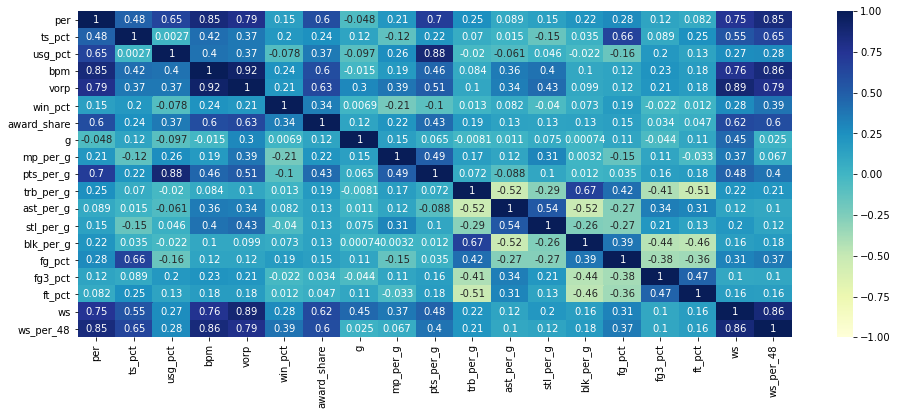

In [32]:
import seaborn as sns

# correlation matrix
stats = df_historical.drop(["player", "season", "votes_first", "points_won", "points_max"], axis=1)

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(stats.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", ax=ax)

## Visualize award share

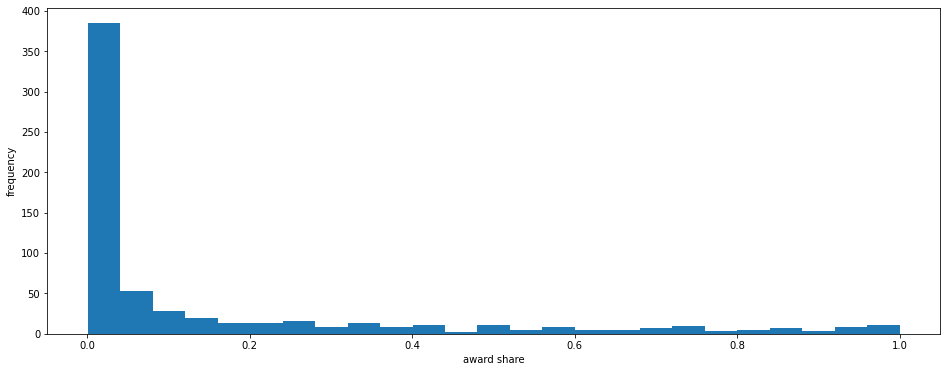

In [34]:
# histogram of target y: award share

plt.figure(figsize=(16, 6))
plt.hist(df_historical["award_share"], bins = 25)
plt.xlabel("award share")
plt.ylabel("frequency")

plt.show()

## Split the preprocessed dataset (80-20)



In [4]:
# drop unneeded features
X = df_historical.drop(["player", "season", "votes_first", "points_won", "points_max", "award_share"], axis=1).values
y = df_historical["award_share"].values


X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

# normalize features? (try without first)

X_train shape: (528, 18)
X_test shape: (133, 18)


In [5]:
# function to calculate and print performance of a model

def evaluate(pred, gt):
    mae = mean_absolute_error(gt, pred)
    mse = mean_squared_error(gt, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(gt, pred)
    
    print("MAE: {}".format(mae))
    print("MSE: {}".format(mse))
    print("RMSE: {}".format(rmse))
    print("R2: {}".format(r2)) # note: higher r2, better fit

## Train model 1: linear regression

In [6]:
# train linear regression model
lr = LinearRegression()

lr.fit(X_train, y_train)
print("bias: ", lr.intercept_)
print("coefficients: ", lr.coef_)

y_train_pred = lr.predict(X_train)

print("\nLinear regression, prediction for our training set")
evaluate(y_train_pred, y_train)

bias:  1.2718455754044873
coefficients:  [-0.03066619 -1.90557677  0.00786191  0.05459071 -0.03146377  0.3258727
 -0.00866108 -0.02242506  0.01578523  0.01418696  0.02216071 -0.05106223
  0.00628444  0.96708896  0.00417645  0.11382673  0.09393114 -2.53471599]

Linear regression, prediction for our training set
MAE: 0.13018307653115815
MSE: 0.030022700509721313
RMSE: 0.1732705990920598
R2: 0.5555224085387088


##  Train model 2: ridge regression

In [7]:
# train ridge regression model
strengths = [.01, .05, .1, 1.0, 10.0]
best_mse = 0
best_strength = strengths[0]

# find best hyper param 
for strength in strengths:
    rr = Ridge(alpha=strength)
    rr.fit(X_train, y_train)
    
    y_train_pred = rr.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    
    if(mse < best_mse):
        best_mse = mse
        best_strength = strength


# retrain using best hyper param
rr = Ridge(alpha=best_strength)
rr.fit(X_train, y_train)
print("bias: ", lr.intercept_)
print("coefficients: ", lr.coef_)

y_train_pred = rr.predict(X_train)

print("\nRidge regression (lamda={}), prediction for our training set".format(best_strength))
evaluate(y_train_pred, y_train)

bias:  1.2718455754044873
coefficients:  [-0.03066619 -1.90557677  0.00786191  0.05459071 -0.03146377  0.3258727
 -0.00866108 -0.02242506  0.01578523  0.01418696  0.02216071 -0.05106223
  0.00628444  0.96708896  0.00417645  0.11382673  0.09393114 -2.53471599]

Ridge regression (lamda=0.01), prediction for our training set
MAE: 0.13055286537856858
MSE: 0.030058994509156185
RMSE: 0.17337529959355855
R2: 0.5549850861400097


## Train model 3: lasso regression

In [8]:
# train lasso regression model (similar to previous cell)
strengths = [.01, .05, .1, 1.0, 10.0]
best_mse = 0
best_strength = strengths[0]

# find best hyper param 
for strength in strengths:
    lr = Lasso(alpha=strength)
    rr.fit(X_train, y_train)
    
    y_train_pred = rr.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    
    if(mse < best_mse):
        best_mse = mse
        best_strength = strength


# retrain using best hyper param
lasso = Lasso(alpha=best_strength)
lasso.fit(X_train, y_train)
print("bias: ", lasso.intercept_)
print("coefficients: ", lasso.coef_)

y_train_pred = lasso.predict(X_train)

print("\nLasso regression (lamda={}), prediction for our training set".format(best_strength))
evaluate(y_train_pred, y_train)

bias:  -0.17191435249494014
coefficients:  [-0.00543804 -0.          0.01189168  0.          0.0237146   0.
 -0.00379275 -0.00675644  0.          0.01158842  0.01154171 -0.
  0.          0.         -0.         -0.          0.03817172  0.        ]

Lasso regression (lamda=0.01), prediction for our training set
MAE: 0.1369245742423025
MSE: 0.034015881611553785
RMSE: 0.18443394918385764
R2: 0.4964044914866922


## Train model 4: support vector regression

In [9]:
from sklearn.svm import SVR

# train support vector regression model
svr = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=.1)

svr.fit(X_train, y_train)
y_train_pred = svr.predict(X_train)

print("\nSupport vector regression, prediction for our training set")
evaluate(y_train_pred, y_train)


Support vector regression, prediction for our training set
MAE: 0.07693156493934548
MSE: 0.00693228030698196
RMSE: 0.0832603165198281
R2: 0.8973695503112993


## Train model 5: k nearest neighbors regression

In [36]:
from sklearn.neighbors import KNeighborsRegressor

# train train knn regression model
nn = list(range(2, 10))

best_mse = 0
best_n = nn[0]; 

# find best num of neighbors 
for n in nn:
    knn = KNeighborsRegressor(n_neighbors=n)
    knn.fit(X_train, y_train)
    
    y_train_pred = knn.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    
    if(mse < best_mse):
        best_mse = mse
        best_n = n

        
knn = KNeighborsRegressor(n_neighbors=best_n)
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)

print("\nKNN regression (n_neighbors: {}), prediction for our training set".format(best_n))
evaluate(y_train_pred, y_train)


KNN regression (n_neighbors: 2), prediction for our training set
MAE: 0.0601875
MSE: 0.011273476325757575
RMSE: 0.10617662796377353
R2: 0.8330993708228839


## Evaluate the models

In [11]:
# evaluate each model (using test set)



In [12]:
# visualize 

In [13]:
# select best model 

## .. (end) Predict award share 2020-21 NBA season

## Visualize ladder/rankings